In [2]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
sns.set()

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Task 1: Descriptive statistics

**Task summary:**

*Perform EDA on the provided dataset.*

Let's load the dataset using pandas, view column summary and take a look at some example rows:

In [3]:
df = pd.read_csv('colleges-data.tsv', sep='\t')
df.head()

,School,School_Type,SAT,Acceptance,$/Student,Top 10%,%PhD,Grad%
0,Amherst,Lib Arts,1315,22,26636,85,81,93
1,Swarthmore,Lib Arts,1310,24,27487,78,93,88
2,Williams,Lib Arts,1336,28,23772,86,90,93
3,Bowdoin,Lib Arts,1300,24,25703,78,95,90
4,Wellesley,Lib Arts,1250,49,27879,76,91,86


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
School         50 non-null object
School_Type    50 non-null object
SAT            50 non-null int64
Acceptance     50 non-null int64
$/Student      50 non-null int64
Top 10%        50 non-null int64
%PhD           50 non-null int64
Grad%          50 non-null int64
dtypes: int64(6), object(2)
memory usage: 3.2+ KB


No missing (null) values to handle here.

Description provided with the dataset states that **School** can be treated as unique ID, **School_Type** as categorical variable and the rest of the features are numerical. Looks like it is really the case. Let's check **School** and **School_Type** values and their cardinality:

In [5]:
df.School.is_unique

True

In [6]:
SCHOOL_TYPES = list(df.School_Type.unique())    # will be used later
df['School_Type'].value_counts()

Lib Arts    25
Univ        25
Name: School_Type, dtype: int64

So our entries are divided into two categories (25 objects for each one).

Now let's inspect and visualize descriptive statistics that summarize the central tendency, dispersion and shape for numeric columns.

In [7]:
df.describe()

,SAT,Acceptance,$/Student,Top 10%,%PhD,Grad%
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,1263.960000,37.840000,30247.200000,74.440000,90.560000,83.480000
std,62.329591,13.363612,15266.172682,13.515162,8.258972,7.557237
min,1109.000000,17.000000,17520.000000,47.000000,58.000000,61.000000
25%,1225.000000,25.750000,20182.250000,65.000000,86.250000,77.250000
50%,1264.000000,36.000000,24994.500000,76.500000,93.000000,85.500000
75%,1304.500000,47.750000,36803.750000,85.000000,97.750000,89.000000
max,1400.000000,67.000000,102262.000000,98.000000,100.000000,95.000000


Let's make box plots for all numeric columns.

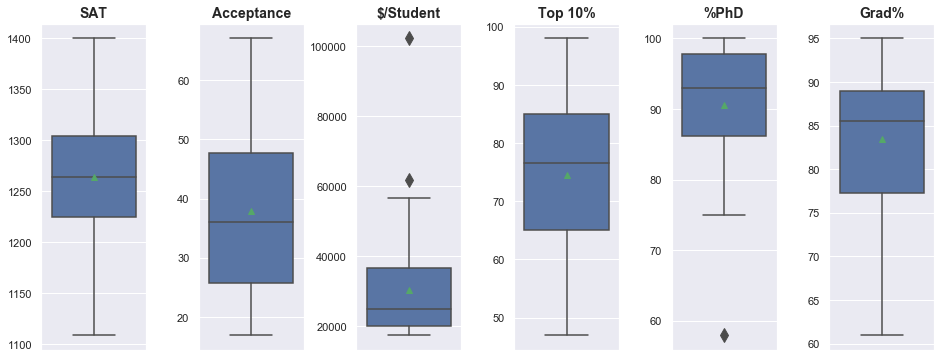

In [8]:
NUMERIC_COLS = ['SAT', 'Acceptance', '$/Student', 'Top 10%', '%PhD', 'Grad%']

def show_boxplot(df):
    f, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_COLS), figsize=(16, 6))
    plt.subplots_adjust(wspace=0.5)
    for index, column_name in enumerate(NUMERIC_COLS):
        sns.boxplot(data=df, y=column_name, ax=axes[index], fliersize=10, showmeans=True)
        axes[index].set_title(column_name, fontsize=14, fontweight='bold')
        axes[index].set_ylabel('')

show_boxplot(df)

We have few outliers in **\$\/Student** (money spent per student) and **\%PhD** (PhD percentage) columns.
It is hard to judge credibility of those values. Colleges that spend $100.000 per student or have 50% of PhD degrees may really exist. One way or another, let's remove these for further analysis as correlation coefficients are not robust to outliers. For the sake of simplicity we will use 3-sigmas method:

In [9]:
def remove_outlier_3sigmas(df, col_name):
    return df.loc[(np.abs(stats.zscore(df[col_name])) < 3)]

df_clean = df.copy()
for col_name in NUMERIC_COLS:
    df_clean = remove_outlier_3sigmas(df_clean, col_name)
    
print('Outliers removed:', len(df) - len(df_clean))

Outliers removed: 3


Let's see the boxplots for the cleaned dataset.

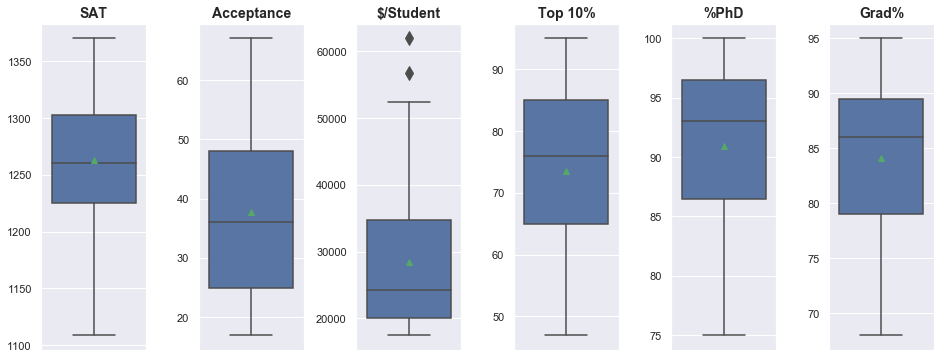

In [10]:
show_boxplot(df_clean)

Much better. Still distribution shapes are not immediately obvious from this. Let's see the histogram for each feature. Along with overall histogram we will plot per-category histograms and see what we can learn from them.

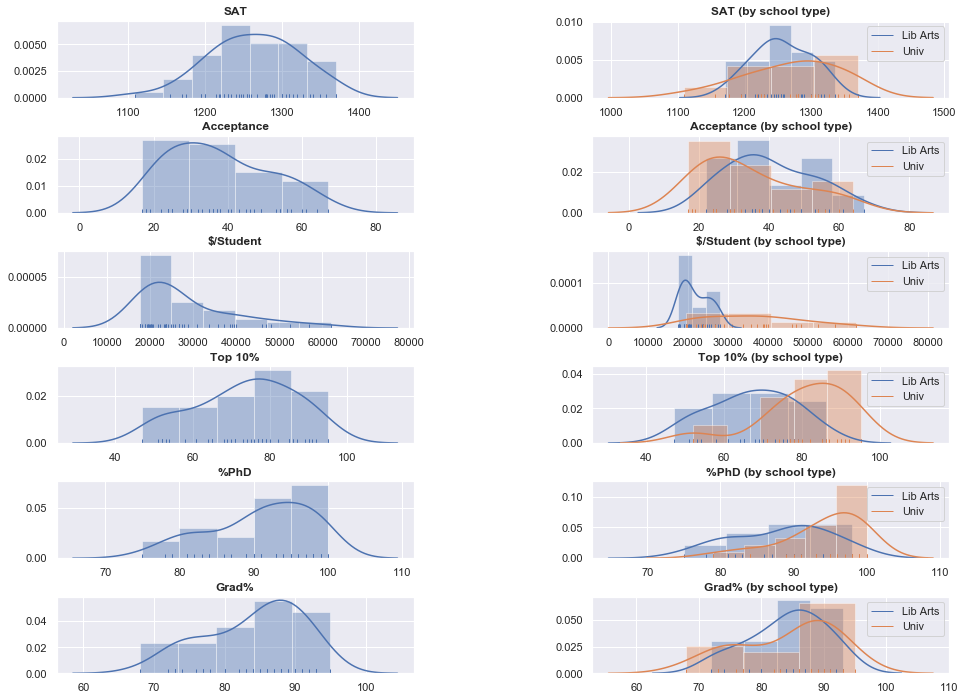

In [11]:
def plot_distributions(df):
    f, axes = plt.subplots(nrows=len(NUMERIC_COLS), ncols=2, figsize=(16, 12))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    for index, column_name in enumerate(NUMERIC_COLS):
        sns.distplot(df[column_name], ax=axes[index][0], rug=True)
        axes[index][0].set_title(column_name, fontsize=12, fontweight='bold')
        axes[index][0].set_xlabel('')
    
        for school_type in SCHOOL_TYPES:
            sns.distplot(df[df.School_Type == school_type][column_name], ax=axes[index][1], rug=True)

        axes[index][1].legend(SCHOOL_TYPES)
        axes[index][1].set_title('%s (by school type)' % column_name, fontsize=12, fontweight='bold')
        axes[index][1].set_xlabel('')

plot_distributions(df_clean)

All distributions are unimodal.
- **SAT**: follows normal distribution pretty well
- **Acceptance**: positively skewed bell shape
- **$\/Student**: positively skewed, does not really look like gaussian, but can be considered a mix of two gaussians (per **School_Type**)
- **Top 10\%**, **\%PhD**, **Grad%**: negatively skewed bell shape

As we could expect distribution parameters for all numeric columns depend on **School_Type**. This effect is most pronounced and visible for the variance of **$\/Student** column.

Now let's take a look at correlations on a pair plot:

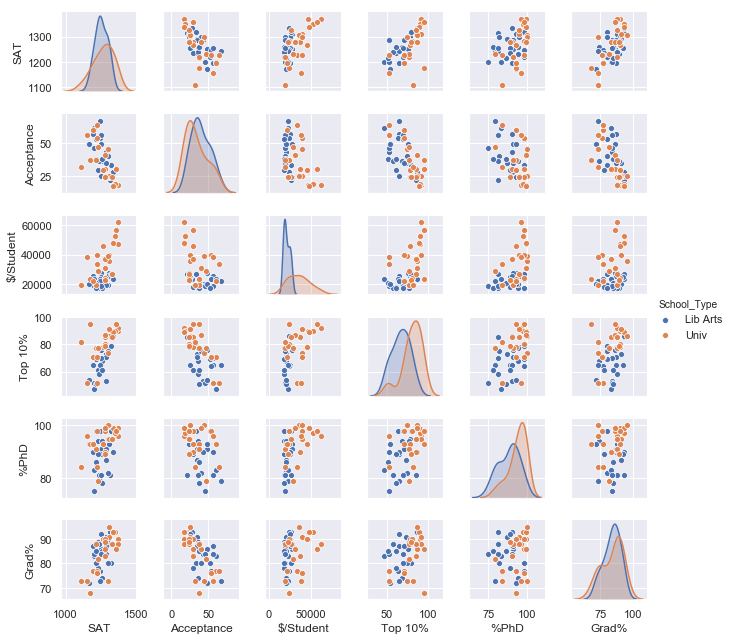

In [12]:
sns.pairplot(df_clean, hue='School_Type', height=1.5)
plt.show()

Some correlations clearly do exist but are hard to read on this chart. We don't see any weird shapes here, so let's consider correlations to be linear and inspect Pearson coefficients on a heatmap:

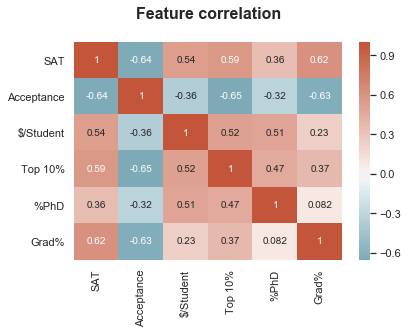

In [13]:
sns.heatmap(df_clean.corr(), center=0, cmap=sns.diverging_palette(220, 20, as_cmap=True), annot=True)
plt.title('Feature correlation\n', fontsize=16, fontweight='bold')
plt.show()

The most obvious takeaway from this is that **Acceptance** ("% of applicants accepted") is negatively correlated with all features that represent some students' or teachers' skills, scores or achievements (**SAT**, **Top 10\%**, **Grad%**, **\%PhD**). Which is no wonder.

Also all these skill-related features are more-or-less correlated with others in this group. That is again something we could expect. **Grad%** and **\%PhD** pair is the only notable exception that shows no correlation at all.

Correlations for **$\/Student** ("money spent per student in dollars") allow very vague interpretations, partly because the exact meaning of this value is not clear from the description.

That's it for our brief EDA.

# Task 2: Stratified sampling

**Task summary:**

*Compare properties of point estimates of expected value and variance of a stratified population for different sampling methods, sample sizes and population distribution parameters.*

Let's begin with defining utility functions that we will use in the modeling process. We will represent stratified population as a DataFrame with two columns (stratum and some numeric value). Sampling methods will be implemented as functions that take that DataFrame and return a new DataFrame of exactly same column structure (a subset of its rows).

In [14]:
def generate_population(strata_params, size=10000):
    """Generate statistical population for further sampling.

    Args:
        strata_params (iterable of dicts): weights, means and variances for stratas
        size (int): size of the population
    Returns:
        DataFrame of shape (size, 2), columns: 'value', 'stratum'    
    """
    dfs = []
    for d in strata_params:
        dfs.append(
            pd.DataFrame({
                'stratum': d['name'],
                'value': np.random.normal(
                    loc=d['mean'], scale=d['std'],
                    size=int(np.round(size * d['weight']))
                )
            })
        )
    return pd.concat(dfs)

In [15]:
def sample_random(df, size, **kwargs):
    """Simple random sampling.
    
    Args:
        df (DataFrame): dataframe to sample from
        size (int): size of the sample
    Returns:
        DataFrame (sampled subset)
    """
    return df.sample(n=size)

In [16]:
def sample_prop(df, size, strata_params, col_name='stratum'):
    """Proportionate sampling.
    
    Args:
        df (DataFrame): dataframe to sample from
        size (int): size of the sample
        strata_params (iterable of dicts): weights, means and variances for stratas
        col_name: column indicating the stratum
    Returns:
        DataFrame (sampled subset)
    """
    n = df.shape[0]
    weights = {d['name']:d['weight'] for d in strata_params}
    return df.groupby(col_name).apply(
        lambda x: x.sample(n=int(np.round(size * weights[x.loc[0][col_name]])))
    )

In [17]:
def sample_optimum(df, size, strata_params, col_name='stratum'):
    """Optimum sampling.
    
    Args:
        df (DataFrame): dataframe to sample from
        size (int): size of the sample
        strata_params (iterable of dicts): weights, means and variances for stratas
        col_name: column indicating the stratum
    Returns:
        DataFrame (sampled subset)
    """
    n = df.shape[0]
    
    w_sigmas = {}
    for stratum_data in strata_params:
        w_sigmas[stratum_data['name']] = stratum_data['std'] * stratum_data['weight']
    sum_w_sigmas = sum(w_sigmas.values())
    weights = {k:v/sum_w_sigmas for k,v in w_sigmas.items()}
    
    return df.groupby(col_name).apply(
        lambda x: x.sample(n=int(np.round(size * weights[x.loc[0][col_name]])))
    )    

The following function will perform repeated sampling from a provided population using different set of strategies and sample sizes, calculate point estimates in question and stores them all in a report DataFrame (one row per sample).

In [18]:
SAMPLE_SIZES = (40, 500)

SAMPLING_STRATEGIES = {
    'random': sample_random,
    'prop': sample_prop,
    'optimum': sample_optimum,
}

def generate_report(population: pd.DataFrame, strata_params, num_samples=1000) -> pd.DataFrame:
    """
    Generate statistics report for given population using different
    sample sizes and sampling strategies.
    
    Args:
        population (DataFrame): statistical population to sample from
        strata_params (iterable of dicts): weights, means and variances for stratas
        num_samples (int): how many times to repeat sampling for any particular set of parameters
    Returns:
        DataFrame (sampling report with sampling parameters and mean/variance estimates)
    """
    report = pd.DataFrame()

    for sample_size, strategy in itertools.product(SAMPLE_SIZES, SAMPLING_STRATEGIES.keys()):
        sampling_func = SAMPLING_STRATEGIES[strategy]

        means = []
        stds = []
        for _ in range(num_samples):
            # Generate the sample
            sample = sampling_func(population, size=sample_size, strata_params=strata_params)
            
            # Estimate mean and standard deviation (according to sampling strategy)
            if strategy == 'random':
                mean = sample['value'].mean()
                std = sample['value'].std()
            elif strategy in ['prop', 'optimum']:
                weights = pd.Series({d['name']:d['weight'] for d in strata_params})

                mean_by_stratum = sample.groupby('stratum')['value'].mean()
                var_by_stratum = sample.groupby('stratum')['value'].var()
                
                mean = np.sum(mean_by_stratum * weights)
                var = (
                    np.sum(var_by_stratum * weights)
                    + np.sum(weights * (mean - mean_by_stratum) ** 2)
                )
                std = np.sqrt(var)
            else:
                raise ValueError('Unknown sampling strategy: %s', strategy)

            means.append(mean)
            stds.append(std)

        report = pd.concat([
            report,
            pd.DataFrame({
                'sample_size': sample_size,
                'strategy': strategy,
                'mean': means,
                'std': stds,
            }),
        ])
    return report

This one is used to plot the results.

In [19]:
def plot_report(report: pd.DataFrame, actual_mean=None, actual_std=None):
    """Plot statistics report using the boxplots.
    
    Args:
        report (DataFrame): sampling report (as returned by `generate_report`)
        actual_mean (float): mean of the population to plot (optional)
        actual_std (float): standard deviation of the population to plot (optional)
    Returns:
        None
    """
    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    sns.boxplot(x="strategy", y="mean", hue='sample_size', data=report, ax=axes[0])
    sns.boxplot(x="strategy", y="std", hue='sample_size', data=report, ax=axes[1])
    
    if actual_mean:
        axes[0].axhline(actual_mean, 0, 1, color='green')
    if actual_std:
        axes[1].axhline(actual_std, 0, 1, color='green')
    
    axes[0].set_title('Mean', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Sampling strategy', fontsize=14)
    axes[0].set_ylabel('')
    axes[1].set_title('Standard deviation', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Sampling strategy', fontsize=14)
    axes[1].set_ylabel('')

Having written the utility code we can start generating various populations and compare sampling methods on them.

We assume that our population is comprised of three strata with different weights. Let's model three such populations.

### Population 1: matching expected values + matching variances

In [20]:
strata_params1 = (
    dict(name='0', mean=0, std=1, weight=0.5),
    dict(name='1', mean=0, std=1, weight=0.3),
    dict(name='2', mean=0, std=1, weight=0.2),
)
population1 = generate_population(strata_params1, size=10000)
report1 = generate_report(population1, strata_params1)

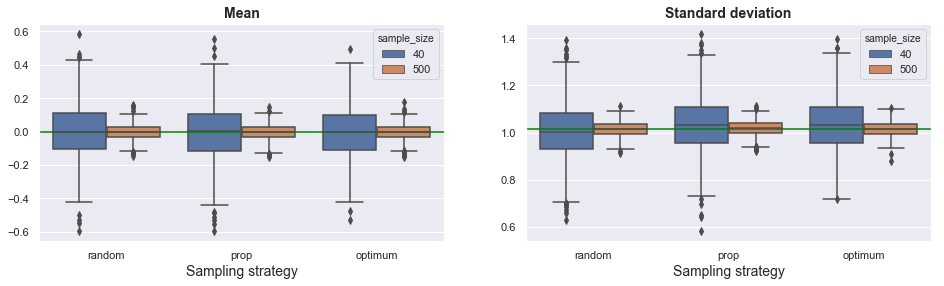

In [21]:
plot_report(report1, actual_mean=population1.value.mean(), actual_std=population1.value.std())

**Conclusion**

We see here that for such an edge case (equal expected values and variance for all stratas) proportionate or optimum sampling methods do not have any advantages over random sampling. They all do the same thing in the end of the day. 

### Population 2: different expected values + matching variances

In [22]:
strata_params2 = (
    dict(name='0', mean=0, std=1, weight=0.5),
    dict(name='1', mean=2, std=1, weight=0.3),
    dict(name='2', mean=4, std=1, weight=0.2),
)
population2 = generate_population(strata_params2, size=10000)
report2 = generate_report(population2, strata_params2)

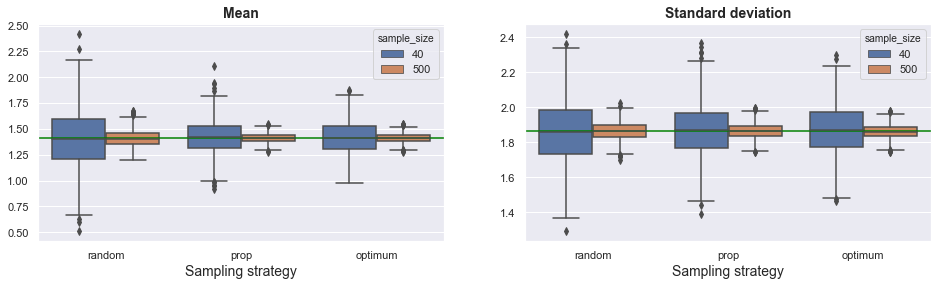

In [23]:
plot_report(report2, actual_mean=population2.value.mean(), actual_std=population2.value.std())

**Conclusion**

Here we see a different picture. All the stratas have the same variance, so proportional and optimum sampling are technically equivalent here, and both converge to the true value of the estimated parameter much faster than random sampling (thus requiring fewer sample sizes for the same estimation accuracy).

### Population 3: different expected values + different variances

In [24]:
strata_params3 = (
    dict(name='0', mean=0, std=0.5, weight=0.5),
    dict(name='1', mean=10, std=2, weight=0.3),
    dict(name='2', mean=20, std=8, weight=0.2),
)
population3 = generate_population(strata_params3, size=10000)
report3 = generate_report(population3, strata_params3)

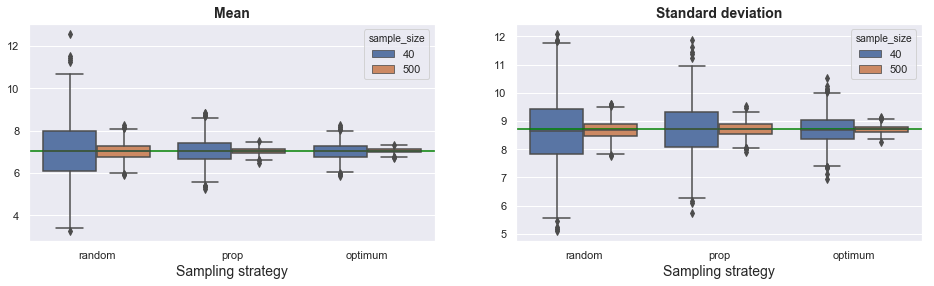

In [25]:
plot_report(report3, actual_mean=population3.value.mean(), actual_std=population3.value.std())

**Conclusion**

When both means and variance differ across the stratas optimum sampling does its best. It converges faster than proportionate sampling which in its turn does it faster than random sampling.

Anyway all three converge to the same values (just as in two previous cases).

# Task 3: SPRT

**Task summary:**

*sdsd.*



In [26]:
def get_sample(means, weights, std=1, size=1000):
    """
    
    """
    sample = np.concatenate([
        np.random.normal(loc=mean, scale=std, size=int(np.round(weight * size)))
        for mean, weight in zip(means, weights)
    ])
    np.random.shuffle(sample)
    return sample

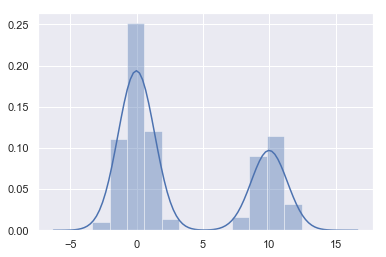

In [27]:
s = get_sample([0, 10], [2, 1])
sns.distplot(s)
plt.show()

In [28]:
def sprt_mean_test(sample, means, std=1, alpha=0.1, beta=0.1):
    
    a = np.log(beta / (1 - alpha))
    b = np.log((1 - beta) / alpha)
    s = 0

    for step, x in enumerate(sample):
        
        # TODO: swap?
        
        log_likelihood_ratio = np.log(     
            stats.norm.pdf(x, loc=means[1], scale=std)
            / stats.norm.pdf(x, loc=means[0], scale=std)
        )
        s = s + log_likelihood_ratio
        if s <= a:
            return False, step      # reject H1, accept H0
        elif s >= b:
            return True, step      # reject H0, accept to H1
    raise ValueError('Ran out of sample size.')

In [29]:
#means = (1, 1.5)
#weights = (0.5, 0.5)
#
#sample = get_sample(means, weights)
#sprt_mean_test(sample, means)

In [40]:
def generate_sprt_report(means, alpha=0.1, beta=0.1):
    sprt_report = pd.DataFrame()

    for weight in np.linspace(0, 1, num=5):
        decision_array = []
        num_steps_array = []
        for _ in range(1000):
            sample = get_sample(means, [weight, 1 - weight])
            decision, num_steps = sprt_mean_test(sample, means, alpha=alpha, beta=beta)
            decision_array.append(decision)
            num_steps_array.append(num_steps)
            sprt_report = pd.concat([
                sprt_report,
                pd.DataFrame({
                    'weight': weight,
                    'decision': decision_array,
                    'num_steps': num_steps_array,
                })
            ])
    return sprt_report

In [41]:
def plot_sprt_report(report: pd.DataFrame):
    g = sns.boxplot(x="weight", y="num_steps", showmeans=True, data=report)
    g.set_title('SPRT report', fontsize=16, fontweight='bold')
    g.set_xlabel('Weight', fontsize=14)
    g.set_ylabel('Number of steps', fontsize=14)

In [42]:
sprt_report = generate_sprt_report(means=(1, 1.5), alpha=0.05, beta=0.1)

KeyboardInterrupt: 

In [ ]:
plot_sprt_report(sprt_report)

In [ ]:
h0_subset = sprt_report[sprt_report.weight == 1]
h1_subset = sprt_report[sprt_report.weight == 0]

type1_error_rate = len(h0_subset[h0_subset.decision == True]) / len(h0_subset)
type2_error_rate = len(h1_subset[h1_subset.decision == False]) / len(h1_subset)

print('Type I error rate: %.2f' % type1_error_rate)
print('Type II error rate: %.2f' % type2_error_rate)

In [39]:
# TODO: plot number type I and type II errors depending on aplha and beta